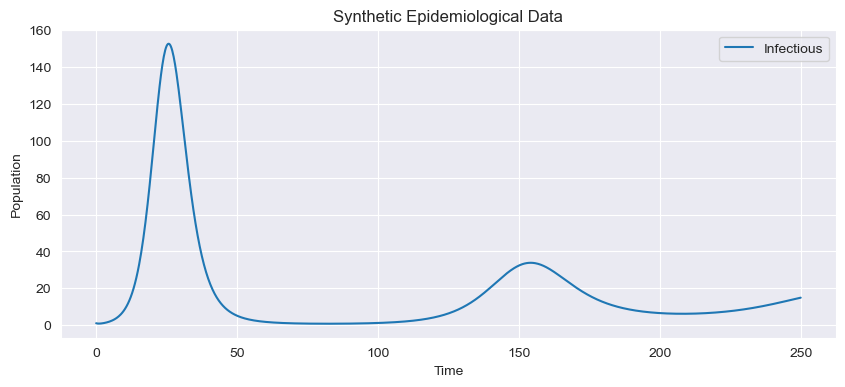

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.spatial.distance import pdist, squareform

# Parameters for the extended SEIR model
beta = 0.3  # Infection rate
sigma = 0.1  # Transition from exposed to infectious
gamma = 0.1  # Recovery rate
N= 1000 # population
# Initial conditions
S0 = N  # Initial fraction of susceptible individuals
E0 = 0.0001  # Initial fraction of exposed individuals
I0 = 1 # Initial fraction of infectious individuals
R0 = 0.0  # Initial fraction of recovered individuals
epsilon=0.002
noise_intensity = 1e-3

def sim_SEIR(pars, init, t, random_noise):
    beta, sigma, gamma, epsilon = pars
    S0, E0, I0, R0 = init

    # Initialize arrays to store S, E, I, and R values
    S = np.zeros(len(t))
    E = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))

    # Initial conditions
    S[0] = S0
    E[0] = E0
    I[0] = I0
    R[0] = R0

    # Simulate the extended SEIR model with waves
    for i in range(1, len(t)):
        dS = -beta * S[i-1] * I[i-1]/N + R[i-1]*epsilon
        dE = beta * S[i-1] * I[i-1]/N - sigma * E[i-1]
        dI = sigma * E[i-1] - gamma * I[i-1]
        dR = gamma * I[i-1]-R[i-1]*epsilon
        
        if random_noise:
            noise = noise_intensity * np.random.randn()
    
            if I[i-1] + dI + noise >= 0:
                dI += noise
            else:
                dI = -I[i-1]

        S[i] = S[i-1] + dS
        E[i] = E[i-1] + dE
        I[i] = I[i-1] + dI
        R[i] = R[i-1] + dR
    return S, E, I, R


pars=[beta, sigma, gamma, epsilon]
init = [S0, E0, I0, R0]
#t = np.linspace(0, 250, 1000, endpoint=True)
# time (0,T,n*k), n: number of data, n*k discretization size
n=250
k=4
t = np.linspace(0, 250, n*k+1, endpoint=True)
S, E, I, R = sim_SEIR(pars, init, t, random_noise=False)


    # Plot the synthetic epidemiological data
plt.figure(figsize=(10, 4))

plt.plot(t, I, label="Infectious")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Synthetic Epidemiological Data")
plt.legend()
plt.show()


### Simulated data with a SEIR model  

The extended SEIR model with loss of immunity is described by the following differential equations:

\begin{align*}
\frac{dS}{dt} &= -\beta SI + \epsilon R \\
\frac{dE}{dt} &= \beta SI - \sigma E \\
\frac{dI}{dt} &= \sigma E - \gamma I \\
\frac{dR}{dt} &= \gamma I - \epsilon R
\end{align*}

where:
\begin{align*}
S(t) & : \text{Number of susceptible individuals at time } t \\
E(t) & : \text{Number of exposed individuals at time } t \\
I(t) & : \text{Number of infectious individuals at time } t \\
R(t) & : \text{Number of recovered individuals at time } t \\
\beta & : \text{Infection rate} \\
\sigma & : \text{Transition from exposed to infectious rate} \\
\gamma & : \text{Recovery rate} \\
\epsilon & : \text{Rate of loss of immunity} \\
\end{align*}

The initial conditions for this model are:
\begin{align*}
S(0) &= 0.9 \text{ (Initial fraction of susceptible individuals)} \\
E(0) &= 0.0001 \text{ (Initial fraction of exposed individuals)} \\
I(0) &= 0 \text{ (Initial fraction of infectious individuals)} \\
R(0) &= 0 \text{ (Initial fraction of recovered individuals)}
\end{align*}

The model simulates the dynamics of the extended SEIR system with loss of immunity, and the plot shows the fraction of the population that is infectious over time.


We simulated observed incidence data by assuming a negative binomial model, using the incidence simulated with the SEIR model ($I$):
$$
y_i \sim N B\left(I\left(t_i\right), \omega, \theta\right),
$$
In this model, each observed value, denoted as $y_i$, follows a negative binomial distribution with parameters 
$\omega$ and $\theta$, where I(t_i) represents the incidence at time $t_i$.

We assume conditional independence in the data, which means that each observed data point is independent of the others. This assumption simplifies the modeling and analysis of the data

In [7]:
def syn_data(theta, omega, th):
    pars, init, t =theta
    S, E, I, R = sim_SEIR(pars, init, t, random_noise=False)
    mu = I
    rr = mu / (omega - 1.0 + th * mu)
    q = 1.0 / (omega + th * mu)
    Output_trace = nbinom.rvs(rr[1:], q[1:])
    return Output_trace


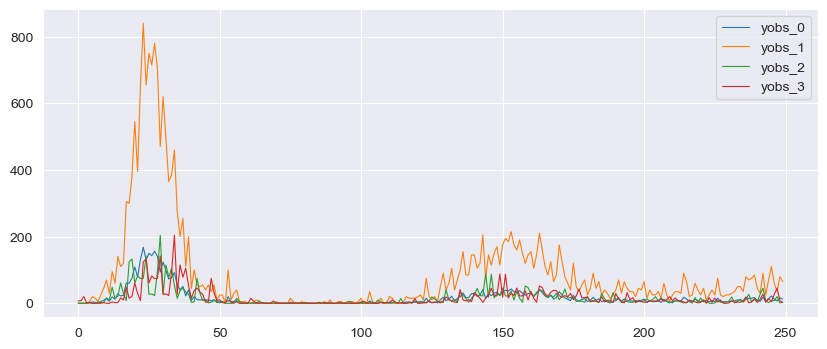

In [8]:
theta=[pars, init, t]
Yobs=[]
Omega=[2,3,4,5]
Theta=[0.01, 0.3, 0.4,0.4]
for i in range(4):
    yobs= syn_data(theta, omega=Omega[i], th=Theta[i])
    Yobs.append(yobs[::k])

#Yobs[1] = 5*Yobs[0]
#Yobs[3]= np.roll(Yobs[2], 5)
plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(Yobs[i],lw=0.8, label='yobs_%s'%i)
#plt.plot(Yobs[0][])
plt.legend()


## Multilevel Wavelet Decomposition using `wavedec`

We employed the discrete wavelet transformation utilizing the Daubechies 4 wavelet family to decompose the data into multiple levels. This decomposition in the time-frequency domain enables us to interpret temporal variability effectively.

During this process, coefficients at different scales and positions are generated. At each level (\(L\)), we obtain two sets of coefficients: approximation coefficients (\(cA_L\), representing low-frequency components) and detail coefficients (\(cD_L\), representing high-frequency components). Both \(cA_L\) and \(cD_L\) have a length of \(N / 2^L\). \(cA_L\) captures information about the overall trend of the signal, while \(cD_L\) contains high-frequency details.

For the wavelet decomposition, we utilized the PyWavelets library, specifically the `pywt.wavedec` function. To determine the appropriate decomposition level, we employed the `pywt.dwt_max_level` function. The `pywt.wavedec` function returns the coefficients \((cAL, cD1, cD2, ..., cDL)\).

We constructed the coefficient vector \(C_{\text{wavelet}}\) as follows: \(C_{\text{wavelet}} = (cAL, cD1, cD2, ..., cDL)\). These wavelet coefficients capture the signal's characteristics across various scales and positions in both the time and frequency domains.



#### Example (Haar Wavelet Decomposition):

**Original series:**
| 10 |  4  |  5  |  7  |  8  |  2  |  3  | 13 |
|----|-----|-----|-----|-----|-----|-----|----|

**Level 1:**
|  7  |  6  |  5  |  8  |     |  3  |  -1 |  3  |  -5 |
|-----|-----|-----|-----|-----|-----|-----|-----|------|

**Level 2:**
| 13/2 | 13/2 |     | 1/2 | -3/2 |
|------|------|-----|------|-------|

**Level 3:**
| 13/2 |      |  0  |
|------|------|-----|




In [9]:
import pywt
wavelet = 'db4'; level = 4
Coeff = [pywt.wavedec(yobs, wavelet, level=level) for yobs in Yobs]
Coeff_flat= [np.concatenate(pywt.wavedec(yobs, wavelet, level=level)) for yobs in Yobs]

In [10]:
def example():
    Coeff_ex=pywt.wavedec(Yobs[0], wavelet='db4', level=2)
    fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=False)
    axes[0,0].plot(Yobs[0][:50])
    axes[0,1].plot(Coeff_ex[0])
    axes[1,0].plot(Coeff_ex[1])
    axes[1,1].plot(Coeff_ex[2])
    #axes[2,0].plot(Coeff_ex[3])
    #axes[2,1].plot(Coeff_ex[4])
    len(np.concatenate(Coeff_ex))

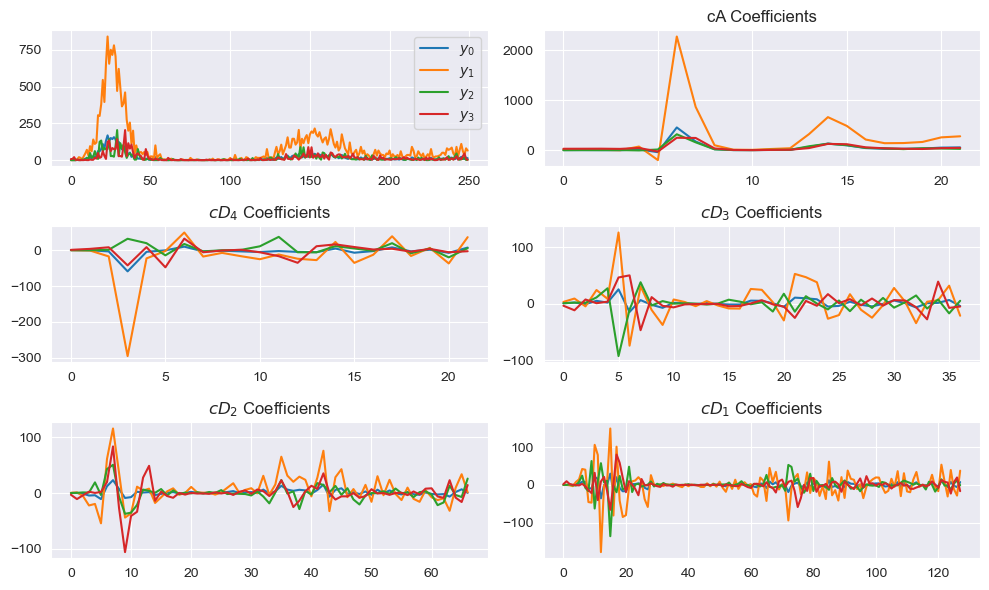

In [11]:

def plot_wavelet_coeff(Coeff,Yobs):
    n_ts = len(Yobs) # number of time series Yobs1, Yobs2,...,Yobsn_ts
    coeff_labels = ['cA', r'$cD_4$', r'$cD_3$', r'$cD_2$', r'$cD_1$']
    num_coefficients = len(coeff_labels)

    num_rows = int(np.ceil(num_coefficients / 2))
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6), sharex=False)

    # Plot each coefficient in a subplot
    for i in range(n_ts):
        axes[0,0].plot(Yobs[i], label='$y_%s$'%i)

    for j in range(n_ts):
        c = Coeff[j]

        for i, label in enumerate(coeff_labels):
            i=i+1
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            #print(row)
            #axes[i+1].plot(c_mu1[i], label='mu1')
            ax.plot(c[i-1], label='$y_%s$'%j)


    for i,label in enumerate(coeff_labels):
            i=i+1
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            ax.set_title(f'{label} Coefficients')

    axes[0,0].legend()
    plt.tight_layout()
    #plt.xlabel('Sample Index')
    plt.show()

plot_wavelet_coeff(Coeff,Yobs)




In [228]:
import numpy as np
import pywt

# Example time series data (replace with your own data)


# Wavelet parameters
wavelet = 'db4'
level = 4

def compute_phase():
    # Calculate wavelet coefficients for both signals
    coefficients1 = pywt.wavedec(mu1[::4], wavelet, level=level)
    coefficients2 = pywt.wavedec(mu2[::4], wavelet, level=level)

    # Initialize an empty array to store phase differences
    phase_differences = []

    # Calculate phase differences at each decomposition level
    for i in range(len(coefficients1)):
        phase1 = np.angle(coefficients1[i])
        phase2 = np.angle(coefficients2[i])
        #print(phase1)
        phase_diff = np.abs(phase1 - phase2)
        phase_differences.append(phase_diff)

    # Visualize phase differences or perform further analysis
    return phase_differences
#ph_diff = compute_phase()
#print(np.angle(coefficients1[0][5]))
#print(coefficients1[0][5])

In [229]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Example time series data (replace with your own data)

def hist_phase(decomposition_level):
    signal1 = mu1[::4]
    signal2 = mu2[::4]

    # Wavelet parameters
    wavelet = 'db4'
    level = 4

    # Calculate wavelet coefficients for both signals
    coefficients1 = pywt.wavedec(signal1, wavelet, level=level)
    coefficients2 = pywt.wavedec(signal2, wavelet, level=level)

    # Choose a specific decomposition level (e.g., level 1) for the phase histogram
    phase_angles1 = np.angle(coefficients1[decomposition_level])
    phase_angles2 = np.angle(coefficients2[decomposition_level])

    # Create phase histograms
    bins = 30  # Number of bins in the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(phase_angles1, bins=bins, alpha=0.5, label='Signal 1')
    plt.hist(phase_angles2, bins=bins, alpha=0.5, label='Signal 2')
    plt.xlabel('Phase Angle')
    plt.ylabel('Frequency')
    plt.title(f'Phase Histogram at Decomposition Level {decomposition_level}')
    plt.legend()
    plt.show()

#hist_phase(0)

In [230]:
#Coeff_flat

In [135]:
pairwise_distances_e = pdist(Coeff_flat, metric='euclidean')
pairwise_distances_se = pdist(Coeff_flat, metric='seuclidean')
pairwise_distances_cos = pdist(Coeff_flat, metric='cosine')
pairwise_distances_bc = pdist(Coeff_flat, metric='braycurtis')
pairwise_distances_corr = pdist(Coeff_flat, metric='correlation')
pairwise_distances_cb = pdist(Coeff_flat, metric='dice')
# Convert the pairwise distances to a square dissimilarity matrix
#dissimilarity_matrix = squareform(pairwise_distances)
#The distance function can be ‘braycurtis’, ‘canberra’,
#‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, 
#‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’,
#‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’,
#‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

# correlation A lower correlation distance implies higher similarity between vectors.

# canberra, cosine, braycurtis
print(pairwise_distances_e)
print(pairwise_distances_se)

[2155.49317705  419.0156786   560.14335514 2103.13725874 2235.47665732
  726.64877188]
[23.65269948 14.7874229  17.26915535 29.86181016 29.45099535 21.83046888]


In [136]:
distance_matrix = squareform(pairwise_distances_cos)
#distance_matrix = squareform(1-pairwise_distances_cos)
distance_matrix

array([[0.        , 0.        , 0.16054428, 0.31253616],
       [0.        , 0.        , 0.16054428, 0.31253616],
       [0.16054428, 0.16054428, 0.        , 0.45486786],
       [0.31253616, 0.31253616, 0.45486786, 0.        ]])

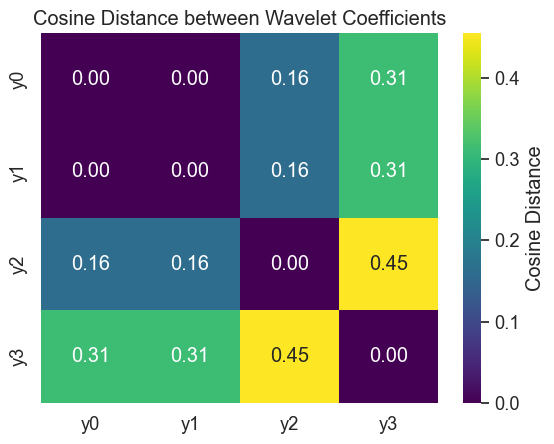

In [137]:
import seaborn as sns
sns.set(font_scale=1.2)
sns.heatmap(distance_matrix, annot=True, cmap='viridis', xticklabels=['y0', 'y1', 'y2','y3'],
            yticklabels=['y0', 'y1', 'y2', 'y3'], fmt=".2f", cbar_kws={'label': 'Cosine Distance'})

plt.title('Cosine Distance between Wavelet Coefficients')
plt.show()

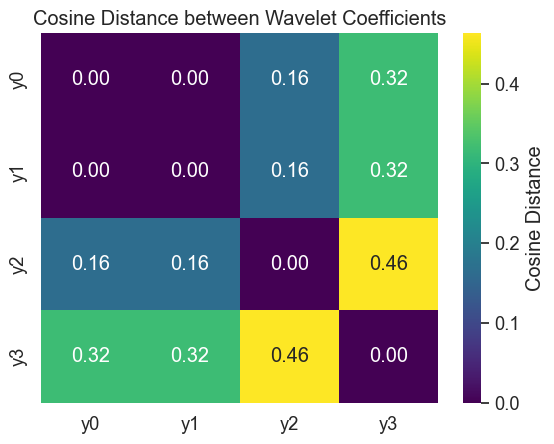

In [139]:
distance_matrix = squareform(pairwise_distances_corr)
import seaborn as sns
sns.set(font_scale=1.2)
sns.heatmap(distance_matrix, annot=True, cmap='viridis', xticklabels=['y0', 'y1', 'y2','y3'],
            yticklabels=['y0', 'y1', 'y2', 'y3'], fmt=".2f", cbar_kws={'label': 'Cosine Distance'})

plt.title('Cosine Distance between Wavelet Coefficients')
plt.show()